In [248]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
from tempfile import TemporaryDirectory


In [249]:
root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                    id = int(os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file_path)))).replace('sub-', ''))
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

# print the path of the first image
print('\nFirst Image Path in Dataset: ')
print(dataset[0].mri.path)
print('ID:', dataset[0]['id'])

print('\nFirst Image Dimensions in Dataset: ')
print(dataset[0].spatial_shape)


Number of Images in Dataset: 245

First Image Path in Dataset: 
Dataset\Peking_1\sub-1038415\ses-1\anat\sub-1038415_ses-1_run-1_T1w.nii.gz
ID: 1038415

First Image Dimensions in Dataset: 
(128, 256, 256)


In [250]:
# import os
# import pandas as pd

# # List all subdirectories in the root directory
# subdirectories = [x[0] for x in os.walk(root_dir)]

# # Create an empty DataFrame
# df = pd.DataFrame()

# # Iterate over the subdirectories
# for subdir in subdirectories:
#     # Check if the subdirectory contains a .csv file
#     if os.path.exists(os.path.join(subdir, 'participants.csv')):
#         # Load the .csv file into a DataFrame
#         new_df = pd.read_csv(os.path.join(subdir, 'participants.csv'))
#         # Append the new DataFrame to the main DataFrame
#         df = df.add(new_df, fill_value=0)

# # Print the resulting DataFrame
# print(df)

In [251]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.tsv in ' + subdir)
        new_df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)
        new_df = new_df[['participant_id', 'age', 'gender', 'dx']]
        df = pd.concat([df, new_df], ignore_index=True)

# Print the resulting DataFrame
df.head()


Found participants.tsv in Dataset\Peking_1
Found participants.tsv in Dataset\Peking_2
Found participants.tsv in Dataset\Peking_3


,participant_id,age,gender,dx
0,1038415,14.92,Male,ADHD-Inattentive
1,1201251,12.33,Male,ADHD-Inattentive
2,1245758,8.58,Female,Typically Developing Children
3,1253411,8.08,Male,Typically Developing Children
4,1419103,9.92,Female,Typically Developing Children


In [252]:
# Assign each row of the df to the corresponding subject in the dataset
for subject in dataset:
    subject_id = subject['id']
    if subject_id not in df['participant_id'].values:
        print(subject_id + ' dataframe does not have this subject_id')
    subject['age'] = df.loc[df['participant_id'] == subject_id, 'age'].values[0]
    subject['gender'] = df.loc[df['participant_id'] == subject_id, 'gender'].values[0]
    subject['dx'] = df.loc[df['participant_id'] == subject_id, 'dx'].values[0]


In [253]:
for subject in dataset:
    if subject['dx'] != 'Typically Developing Children':
        subject['dx'] = 'ADHD'

## Exploratory Data Analysis

In [254]:
shapes = set()
for subject in dataset:
    shapes.add(subject['mri'].shape)
print("Unique shape values in the dataset:")
print(shapes)

Unique shape values in the dataset:
{(1, 176, 208, 256), (1, 128, 256, 256), (1, 128, 240, 256), (1, 192, 256, 256), (1, 176, 512, 512)}


In [255]:
voxel_spacing = set()
for subject in dataset:
    voxel_spacing.add(subject['mri'].spacing)

print("Unique voxel spacing values in the dataset:")
for spacing in voxel_spacing:
    print(spacing)

Unique voxel spacing values in the dataset:
(1.2999999523162842, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0000001192092896, 1.0000001192092896)
(1.0, 0.9999996423721313, 0.9999996423721313)
(1.0, 0.5, 0.5)
(1.3300000429153442, 1.0, 1.0)
(1.3299999237060547, 1.0, 1.0)
(1.0, 1.0000004768371582, 1.0000004768371582)
(1.0, 0.9375, 0.9375)
(1.3300001621246338, 1.0, 1.0)
(1.3300000429153442, 0.99609375, 0.99609375)


Subject ID: 1038415
Age: 14.92
Gender: Male
Diagnosis: ADHD


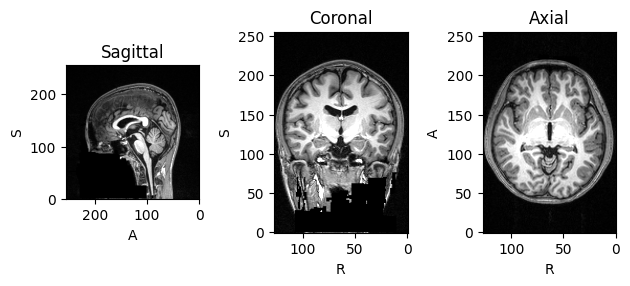

Subject ID: 1056121
Age: 13.92
Gender: Male
Diagnosis: Typically Developing Children


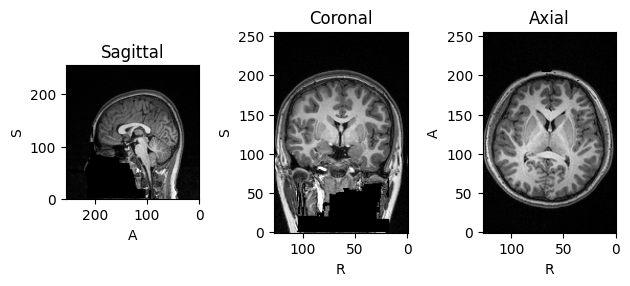

Subject ID: 1113498
Age: 14.83
Gender: Female
Diagnosis: Typically Developing Children


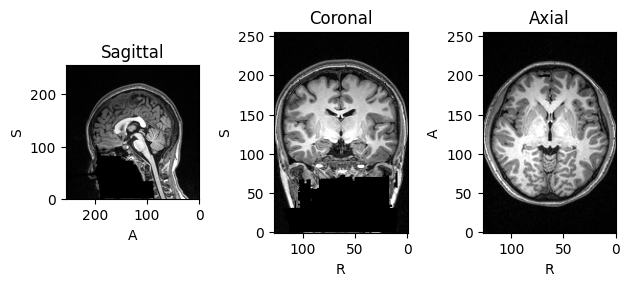

Subject ID: 1133221
Age: 12.33
Gender: Male
Diagnosis: ADHD


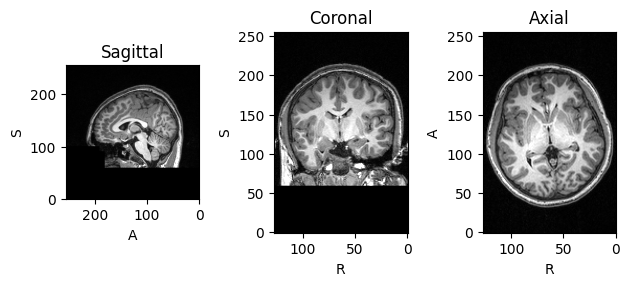

Subject ID: 1139030
Age: 11.33
Gender: Female
Diagnosis: Typically Developing Children


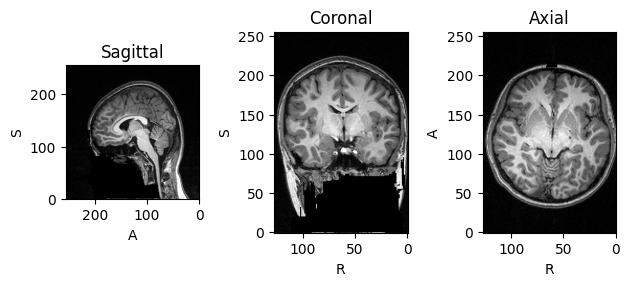

In [263]:
for i in range(5):
    subject = dataset[i]
    image = subject['mri']
    print('Subject ID:', subject['id'])
    print('Age:', subject['age'])
    print('Gender:', subject['gender'])
    print('Diagnosis:', subject['dx'])
    image.plot()
    plt.show()

